# import library

In [1]:
from functools import partial

import numpy as np
import pandas as pd
import os
import random
import time

import tensorflow as tf, re, math
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model, Sequential
from tensorflow.keras import backend as K

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import gc
import uproot

### Checking for TPUs

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()
    
!nvidia-smi

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
/usr/bin/sh: nvidia-smi: command not found


### Loading the data

In [3]:
# This is literally every feature that gets popped out of the ntuplizer
def get_features():
    return ['FatJet_pt', 'FatJet_eta', 'FatJet_phi', 'FatJet_DDX_jetNSecondaryVertices', 'FatJet_DDX_jetNTracks', 'FatJet_DDX_z_ratio', 'FatJet_Proba', 'FatJet_area', 'FatJet_jetId', 'FatJet_lsf3', 'FatJet_mass', 'FatJet_msoftdrop', 'FatJet_rawFactor', 'FatJet_n2b1', 'FatJet_n3b1', 'FatJet_tau1', 'FatJet_DDX_tau1_flightDistance2dSig', 'FatJet_DDX_tau1_trackEtaRel_0', 'FatJet_DDX_tau1_trackEtaRel_1', 'FatJet_DDX_tau1_trackEtaRel_2', 'FatJet_DDX_tau1_trackSip3dSig_0', 'FatJet_DDX_tau1_trackSip3dSig_1', 'FatJet_DDX_tau1_vertexDeltaR', 'FatJet_DDX_tau1_vertexEnergyRatio', 'FatJet_DDX_tau1_vertexMass', 'FatJet_tau2', 'FatJet_DDX_tau2_flightDistance2dSig', 'FatJet_DDX_tau2_trackEtaRel_0', 'FatJet_DDX_tau2_trackEtaRel_1', 'FatJet_DDX_tau2_trackEtaRel_3', 'FatJet_DDX_tau2_trackSip3dSig_0', 'FatJet_DDX_tau2_trackSip3dSig_1', 'FatJet_DDX_tau2_vertexEnergyRatio', 'FatJet_DDX_tau2_vertexMass', 'FatJet_tau3', 'FatJet_tau4', 'FatJet_DDX_trackSip2dSigAboveBottom_0', 'FatJet_DDX_trackSip2dSigAboveBottom_1', 'FatJet_DDX_trackSip2dSigAboveCharm', 'FatJet_DDX_trackSip3dSig_0', 'FatJet_DDX_trackSip3dSig_1', 'FatJet_DDX_trackSip3dSig_2', 'FatJet_DDX_trackSip3dSig_3', 'FatJet_subjet1_pt', 'FatJet_subjet1_eta', 'FatJet_subjet1_phi', 'FatJet_subjet1_Proba', 'FatJet_subjet1_mass', 'FatJet_subjet1_tau1', 'FatJet_subjet1_tau2', 'FatJet_subjet1_tau3', 'FatJet_subjet1_tau4', 'FatJet_subjet1_n2b1', 'FatJet_subjet1_n3b1', 'FatJet_subjet2_pt', 'FatJet_subjet2_eta', 'FatJet_subjet2_phi', 'FatJet_subjet2_Proba', 'FatJet_subjet2_mass', 'FatJet_subjet2_tau1', 'FatJet_subjet2_tau2', 'FatJet_subjet2_tau3', 'FatJet_subjet2_tau4', 'FatJet_subjet2_n2b1', 'FatJet_subjet2_n3b1', 'FatJet_hadronFlavour', 'FatJet_sv_costhetasvpv', 'FatJet_sv_d3dsig', 'FatJet_sv_deltaR', 'FatJet_sv_dxysig', 'FatJet_sv_enration', 'FatJet_sv_mass', 'FatJet_sv_normchi2', 'FatJet_sv_ntracks', 'FatJet_sv_phirel', 'FatJet_sv_pt', 'FatJet_sv_ptrel', 'FatJet_nFatJetPFCands', 'FatJet_pfcand_max_deltar', 'FatJet_pfcand_mean_deltar', 'FatJet_gen_pt', 'FatJet_gen_eta', 'FatJet_gen_phi', 'FatJet_gen_hadronFlavour']

In [4]:
def get_df(root_file_name, filter_name):
    events = uproot.open(root_file_name, filter_name=filter_name)["tree"]
    df = events.arrays(library="pd")
    return df

features = []
# variables: general
features += ['FatJet_pt', 'FatJet_eta', 'FatJet_phi', 'FatJet_DDX_jetNSecondaryVertices', \
             'FatJet_DDX_jetNTracks', 'FatJet_DDX_z_ratio', 'FatJet_Proba', 'FatJet_area', \
             'FatJet_jetId', 'FatJet_lsf3', 'FatJet_rawFactor', 'FatJet_n2b1', 'FatJet_n3b1', \
            ]

# variables: tau1
features += ['FatJet_tau1', 'FatJet_DDX_tau1_flightDistance2dSig', 'FatJet_DDX_tau1_trackEtaRel_0', \
             'FatJet_DDX_tau1_trackEtaRel_1', 'FatJet_DDX_tau1_trackEtaRel_2', 'FatJet_DDX_tau1_trackSip3dSig_0', \
             'FatJet_DDX_tau1_trackSip3dSig_1', 'FatJet_DDX_tau1_vertexDeltaR', 'FatJet_DDX_tau1_vertexEnergyRatio', \
            ]

# variables: tau2
features += ['FatJet_tau2', 'FatJet_DDX_tau2_flightDistance2dSig', 'FatJet_DDX_tau2_trackEtaRel_0', \
             'FatJet_DDX_tau2_trackEtaRel_1', 'FatJet_DDX_tau2_trackEtaRel_3', 'FatJet_DDX_tau2_trackSip3dSig_0', \
             'FatJet_DDX_tau2_trackSip3dSig_1', 'FatJet_DDX_tau2_vertexEnergyRatio', \
            ]

# variables: tau3 and tau4
features += ['FatJet_tau3', 'FatJet_tau4',]

# variables: track
features += ['FatJet_DDX_trackSip2dSigAboveBottom_0', 'FatJet_DDX_trackSip2dSigAboveBottom_1', \
             'FatJet_DDX_trackSip2dSigAboveCharm', 'FatJet_DDX_trackSip3dSig_0', \
             'FatJet_DDX_trackSip3dSig_1', 'FatJet_DDX_trackSip3dSig_2', 'FatJet_DDX_trackSip3dSig_3', \
            ]

# variables: subjet 1
features += ['FatJet_subjet1_pt', 'FatJet_subjet1_eta', 'FatJet_subjet1_phi', \
             'FatJet_subjet1_Proba', 'FatJet_subjet1_tau1', 'FatJet_subjet1_tau2', \
             'FatJet_subjet1_tau3', 'FatJet_subjet1_tau4', 'FatJet_subjet1_n2b1', 'FatJet_subjet1_n3b1', \
            ]

# variables: subjet 2
features += ['FatJet_subjet2_pt', 'FatJet_subjet2_eta', 'FatJet_subjet2_phi', \
             'FatJet_subjet2_Proba', 'FatJet_subjet2_tau1', 'FatJet_subjet2_tau2', \
             'FatJet_subjet2_tau3', 'FatJet_subjet2_tau4', 'FatJet_subjet2_n2b1', 'FatJet_subjet2_n3b1', \
            ]

# # variables: fatjet sv
# features += ['FatJet_sv_costhetasvpv', 'FatJet_sv_d3dsig', 'FatJet_sv_deltaR', 'FatJet_sv_dxysig', \
#              'FatJet_sv_enration', 'FatJet_sv_normchi2', 'FatJet_sv_ntracks', 'FatJet_sv_phirel', \
#              'FatJet_sv_pt', 'FatJet_sv_ptrel', \
#             ]

features = sorted(features)

root_dir = "/eos/user/a/afriberg/datasets/QCD_samples/"

dirs = os.listdir(root_dir)

first_file = dirs.pop(0)
while ".root" not in first_file:
    first_file = dirs.pop(0)

first_file = root_dir + first_file
df = get_df(first_file, '*')
# Select a particular type of particle 0 means QCD
df.query("FatJet_gen_hadronFlavour == 0", inplace=True)
df.dropna(inplace=True)
df = df[features]
# Prior to this, df is a pandas dataframe
X = df.to_numpy().astype(np.float32)
print(np.shape(X))


for inputfile in dirs:
    if ".root" not in inputfile:
        continue
    inputfile = root_dir + inputfile
    df = get_df(inputfile, '*')
    df.dropna(inplace=True)
    df = df[features]
    # Prior to this, df is a pandas dataframe
    next_data = df.to_numpy().astype(np.float32)
    print(f"next data has shape {np.shape(next_data)}")
    # appending it to the whole thing
    X = np.append(X, next_data, axis=0)

print(f"X has shape {np.shape(X)}")

(376907, 59)
next data has shape (353590, 59)
next data has shape (340485, 59)
next data has shape (74979, 59)
next data has shape (361458, 59)
next data has shape (399367, 59)
X has shape (1906786, 59)


# Run this when you want to add HToBB Data to the tests

In [5]:
new_path = "/eos/user/a/afriberg/datasets/has_B/ZH_HToBB_ZToLL_M125_13TeV_powheg_pythia8.root"
df = get_df(new_path, '*')
# Select a particular type of particle 4 means Charm 5 means B quark?
df.query("FatJet_gen_hadronFlavour == 5", inplace=True)

df.dropna(inplace=True)
df = df[features]

new_X = df.to_numpy()
new_X = new_X.astype("float32")

This scales the HToBB data and the QCD data together, and then splits them in two parts afterwards

In [6]:
# num_new = np.size(new_X, axis=0)
# X = np.append(X, new_X, axis=0)
# print(f"new_X has shape {np.shape(new_X)}\nX has shape {np.shape(X)}")
# print(np.allclose(X[-num_new:, :], new_X))

# Scale our data using a MinMaxScaler that will scale
# each number so that it will be between 0 and 1
scaler = MinMaxScaler()
qcd_data = scaler.fit_transform(X)
bb_data = scaler.transform(new_X)

print(f"X now has shape {np.shape(X)}\n new_X now has shape {np.shape(new_X)}")

X now has shape (1906786, 59)
 new_X now has shape (23350, 59)


In [7]:
# X_qcd = []
# X_bb = []
# scaler.fit_transform(X_qcd)
# scaler.transform(x)
# print(bb_data[np.argmax(bb_data, axis=0)])

## Run this regardless of presence or lack of HToBB data

In [8]:
x_train, x_test = train_test_split(qcd_data, test_size=0.20)
original_dim = np.size(qcd_data, axis=1)
print(original_dim)

59


In [9]:
batch_size = 32

def build_dset(df): 
    df = df.copy()
    dataset = tf.data.Dataset.from_tensor_slices((df, df))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset
    
x_train_dataset = build_dset(x_train)
x_test_dataset = build_dset(x_test)

### loss function

In [10]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the encoding vector."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### build model

In [11]:
def get_encoder(original_dim, latent_dim):
    # Encoder
    encoder_inputs = layers.Input(shape=(original_dim,))
    h = layers.Dense(32, activation='relu')(encoder_inputs)
    h = layers.Dense(16, activation='relu')(h)
    h = layers.Dense(8, activation='relu')(h)
    h = layers.Dense(latent_dim, activation='sigmoid')(h)
    z_mu = layers.Dense(latent_dim, name="z_mean")(h)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)
    z = Sampling()([z_mu, z_log_var])
    
    encoder = Model(encoder_inputs, [z_mu, z_log_var, z], name="encoder")
    return encoder
    
def get_decoder(original_dim, latent_dim):
    decoder_inputs = layers.Input(shape=(latent_dim,))
    d = layers.Dense(8, activation='relu')(decoder_inputs)
    d = layers.Dense(16, activation='relu')(d)
    d = layers.Dense(32, activation='relu')(d)
    d = layers.Dense(original_dim, activation='softmax')(d)
    
    decoder = Model(decoder_inputs, d, name="decoder")
    return decoder

class vae(Model):
    def __init__(self, encoder, decoder, verbose=True, **kwargs):
        super(vae, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        
        if verbose:
            self.encoder.summary()
            self.decoder.summary()

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=-1
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.encoder.trainable_weights + self.decoder.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.encoder.trainable_weights + self.decoder.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def call(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        y_pred = self.decoder(z)
        return y_pred 

### get model

In [12]:
latent_dim = 2

with strategy.scope():
    encoder = get_encoder(original_dim, latent_dim)
    decoder = get_decoder(original_dim, latent_dim)
    model = vae(encoder, decoder)
    model.compile(optimizer=tf.keras.optimizers.Adam(1.e-3))
    #model.compile(optimizer=tf.keras.optimizers.RMSprop())


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 59)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           1920        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           528         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 8)            136         dense_1[0][0]                    
____________________________________________________________________________________________

### train model

In [ ]:
def get_lr_callback():
    lr_start   = 0.000001
    lr_max     = 0.01
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 10
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
    return lr_callback

checkpoint_path = "checkpoints/no_sv_vars.{epoch:05d}.hdf5"
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor = 'val_loss',
                                                 save_weights_only=True,
                                                 save_best_only=False,
                                                 mode = 'min',
                                                 verbose=1)

num_epochs = 30

history = model.fit(
    x_train_dataset,
    shuffle=True,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[cp_callback]
    #callbacks=[cp_callback, get_lr_callback()]
)

In [ ]:
model.evaluate(x_test)
predictions = model.predict(x_test)


In [ ]:
print(history.history.keys())
plt.plot(history.history["loss"])
plt.show()

plt.plot(history.history["loss"][12:])
plt.show()

# Loading a model from a checkpoint

In [13]:
latent_dim = 2
encoder = get_encoder(original_dim, latent_dim)
decoder = get_decoder(original_dim, latent_dim)
model = vae(encoder, decoder)
model.compile(optimizer=tf.keras.optimizers.Adam(1.e-3))
model.evaluate(x_test)
model.load_weights("no_sv_vars_checkpoints/no_sv_vars.00030.hdf5")

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 59)]         0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 32)           1920        input_3[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 16)           528         dense_8[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 8)            136         dense_9[0][0]                    
____________________________________________________________________________________________

# Plotting the test data errors

In [ ]:
predict = model.predict(x_test)
err = np.mean(np.abs(predict - x_test), axis=1)
print(np.shape(err))

bins = np.linspace(0, 0.4, 1000)
# plt.hist(err, density=True)
plt.hist(err, density=True, bins=bins)
plt.xlabel("Mean Absolute Error")
plt.ylabel("Number of events (density)")
# Getting the name of the file we ran on
plt.title("Aggregate QCD Data")
plt.show()


## Trying to predict BB quarks

Adding all of the data together

In [ ]:
qcd_label = np.zeros(shape=(np.size(new_X, axis=0), 1))
bb_label = np.ones(shape=(np.size(x_test, axis=0), 1))

print(np.shape(new_X))
qcd_true = np.hstack((new_X, qcd_label))
print(np.shape(qcd_true))

print(np.shape(x_test))
bb_true = np.hstack((x_test, bb_label))
print(np.shape(bb_true))

Putting all of the data in one place

In [ ]:
# Put all the data together and randomize it
total_matrix = np.append(bb_true, qcd_true, axis=0)
np.random.shuffle(total_matrix)
print(np.shape(total_matrix))
# Making test data with the correct labels (whether its a b quark or not)
test_matrix = total_matrix[:, :original_dim]
test_labels = total_matrix[:, original_dim]
print(np.shape(test_matrix))

Getting the error for every prediction

In [ ]:
predict = model.predict(test_matrix)
diff = test_matrix - predict
mae_err = np.mean(np.abs(diff), axis = 1)
sq_err = np.mean(np.square(diff), axis = 1)

In [ ]:
print(mae_err[np.argmax(mae_err)])
print(mae_err[np.argmin(mae_err)])

bins = 20
bins = np.linspace(0, 25, 100)
plt.hist(mae_err, bins=bins, alpha=0.5, label="MAE Error", density=True)
plt.hist(sq_err, bins=bins, alpha=0.5, label="Mean Square Error", density=True)
plt.show()

### Plotting the latent space distribution

In [ ]:
encoder = model.encoder
z_mean, z_log_var, z = encoder.predict(test_matrix)

In [ ]:
plt.scatter(z[0], z[1])
plt.show()

### Plotting ROC Curves

In [ ]:
mae_fpr, mae_tpr, mae_threshold = roc_curve(test_labels, mae_err)
sq_fpr, sq_tpr, sq_threshold = roc_curve(test_labels, sq_err)

mae_auc = auc(mae_fpr, mae_tpr)
sq_auc = auc(sq_fpr, sq_tpr)

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(mae_fpr, mae_tpr, label="MAE")
# plt.plot(sq_fpr, sq_tpr, label="Mean Square Error")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()

In [14]:
print("Hey. We made it")

Hey. We made it


### Plotting BB error vs QCD error

In [15]:
bb_predict = model.predict(new_X)
qcd_predict = model.predict(X)
bb_err = np.mean(np.abs(bb_predict, new_X), axis=1)
qcd_err = np.mean(np.abs(qcd_predict, X), axis=1)

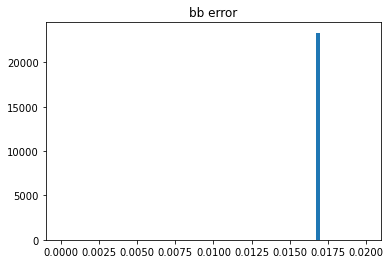

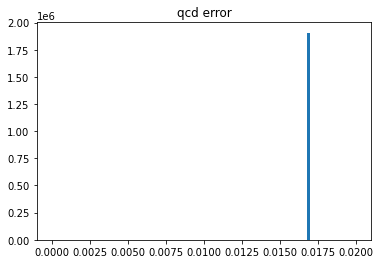

In [19]:
bins=200
bins = np.linspace(0, 0.02, 100)
plt.hist(bb_err, bins=bins)
plt.title("bb error")
plt.show()

plt.hist(qcd_err, bins=bins)
plt.title("qcd error")
plt.show()

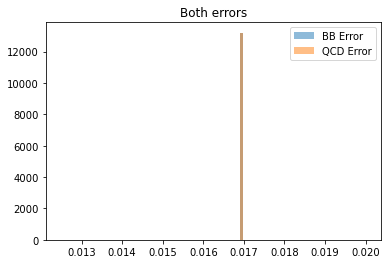

In [23]:
bins=np.linspace(0.0125, 0.02, 100)
alpha=0.5

plt.hist(bb_err, density=True, bins=bins, label="BB Error", alpha=alpha)
plt.hist(qcd_err, density=True, bins=bins, label="QCD Error", alpha=alpha)
plt.title("Both errors")
plt.legend()
plt.show()